# Task 1: Use NLP Techniques to Analyze a Collection of Texts
## Objective:
The goal of this project is to analyze a large collection of consumer complaints using unsupervised natural language processing (NLP) techniques. By applying advanced topic modeling algorithms, this project aims to uncover prevalent themes and latent topics within the data. These insights can provide valuable support to policymakers and organizations in addressing critical consumer issues, enhancing decision-making, and improving service quality.
## Problem Statement:
Consumer complaint data, such as the dataset from the Consumer Financial Protection Bureau (CFPB), is inherently unstructured and noisy. These complaints often contain irregular formatting, varied language usage, and redundant information, making direct systematic analysis challenging. The volume of data further complicates identifying the most pressing concerns. Traditional manual approaches are insufficient to extract meaningful patterns from such data.
Topic modeling offers an effective solution to these challenges by uncovering latent structures and organizing the complaints into coherent themes. This project leverages algorithms like Latent Dirichlet Allocation (LDA), Non-Negative Matrix Factorization (NMF), and BERTopic to identify key topics, enabling a systematic understanding of consumer grievances and supporting data-driven decisions.

# Import Necessary Libraries

In [1]:
# Preprocessing
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Parallel Processing
import swifter

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.decomposition import LatentDirichletAllocation, NMF
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# Evaluation and Visualization
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Load Data

In [2]:
# Define the file path
file_path = "/Users/achshahrm/Library/Mobile Documents/com~apple~CloudDocs/Documents/IU International/Sem 05/Project Data Analysis/project/data/complaints.csv"

# Load the data into a DataFrame
data = pd.read_csv(file_path)

## Inspect Data

### Basic Overview

In [3]:
# Display the first few rows of the DataFrame
data.head(10)

Unnamed: 0           product  \
0           0       credit_card   
1           1       credit_card   
2           2    retail_banking   
3           3  credit_reporting   
4           4  credit_reporting   
5           5  credit_reporting   
6           6  credit_reporting   
7           7  credit_reporting   
8           8  credit_reporting   
9           9  credit_reporting   

                                           narrative  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...  
5  payment history missing credit report made mis...  
6  va date complaint experian credit bureau invol...  
7  account reported abbreviated name full name se...  
8  account reported abbreviated name full name se...  
9  usdoexxxx account reported abbreviated name fu...

In [4]:
# Display the last few rows of the DataFrame
data.tail(10)

Unnamed: 0              product  \
162411      162411       retail_banking   
162412      162412      debt_collection   
162413      162413  mortgages_and_loans   
162414      162414      debt_collection   
162415      162415      debt_collection   
162416      162416      debt_collection   
162417      162417          credit_card   
162418      162418      debt_collection   
162419      162419          credit_card   
162420      162420     credit_reporting   

                                                narrative  
162411  zelle suspended account without cause banking ...  
162412  zero contact made debt supposedly resolved fou...  
162413  zillow home loan nmls nmls actual quote provid...  
162414  zuntafi sent notice willing settle defaulted s...  
162415                                               name  
162416                                               name  
162417                                               name  
162418                                               name  
162419                                               name  
162420                                               name

### General Information

In [5]:
# Display general informations
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


### DataFrame Shape

In [6]:
# Get the DataFrame Shape
print("Shape of DataFrame:", data.shape)

Shape of DataFrame: (162421, 3)


### Columns Names

In [7]:
# List All Column Names
print("Column Names:", data.columns.tolist())

Column Names: ['Unnamed: 0', 'product', 'narrative']


### Value Counts

In [8]:
# Unique Values in a Column
print("Unique Values:\n", data['narrative'].nunique())

Unique Values:
 124472


In [9]:
# Frequency of Each Value
print("Value Counts:\n", data['narrative'].value_counts())

Value Counts:
 narrative
victim identity notified collection creditor several time account belong way received good service company provided police report ftc id theft affidavit signed notarized along sworn statement regarding fraudulent account document submitted credit bureau                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### Missing Values

In [10]:
# Missing Values per Column
data.isnull().sum()

Unnamed: 0     0
product        0
narrative     10
dtype: int64

### Duplicates

In [11]:
# Dulicates in narrative column
data['narrative'].duplicated().sum()

37948

## Clean Data

### Drop Columns

In [12]:
# Drop unnecessary columns
data_cleaned = data.drop(columns=['Unnamed: 0', 'product'])
data_cleaned.columns.tolist()

['narrative']

### Rename Column

In [13]:
# Rename the narrative column
data_cleaned.rename(columns={'narrative': 'complaints_text'}, inplace=True)
data_cleaned.columns.tolist()

['complaints_text']

### Remove Duplicates

In [14]:
# Remove duplicates in the complaints_text column
data_cleaned = data_cleaned.drop_duplicates(subset='complaints_text', keep='first')
data_cleaned['complaints_text'].duplicated().sum()

0

### Remove Missing or Irrelevant Values

In [15]:
# Replace placeholder strings with NaN
data_cleaned['complaints_text'].replace('name', np.nan, inplace=True)
data_cleaned.isnull().sum()

complaints_text    2
dtype: int64

In [16]:
# Drop rows with missing values in 'narrative'
data_cleaned.dropna(subset=['complaints_text'], inplace=True)
data_cleaned.isnull().sum()

complaints_text    0
dtype: int64

### Save Cleaned Data

## Text Preprocessing

In [17]:
# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Define stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Download punkt Tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/achshahrm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/achshahrm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/achshahrm/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Preprocessing Function

In [18]:
# Define a preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [nlp(word)[0].lemma_ for word in tokens]
    
    # Join tokens back into a single string
    return ' '.join(tokens)

### Call Function

In [19]:
# Create a new DataFrame for preprocessed data
data_preprocessed = data_cleaned.head(10000)

# Apply preprocessing to the complaints_text column using parallel processing
data_preprocessed['complaints_text'] = data_preprocessed['complaints_text'].apply(preprocess_text)

### Save Preprocessed Data

# Text Vectorization

## BoW - Bag of Words

In [20]:
# Initialize CountVectorizer for Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Fit and transform the complaints_text column
bow_matrix = bow_vectorizer.fit_transform(data_preprocessed['complaints_text'])

# Convert to DataFrame for easier inspection
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
print("Bag of Words representation created.")
bow_df.head()

Bag of Words representation created.


aa  aadvantage  aag  aargon  abandon  abide  ability  able  abroad  \
0   0           0    0       0        0      0        0     0       0   
1   0           0    0       0        0      0        0     0       0   
2   0           0    0       0        0      0        0     0       0   
3   0           0    0       0        0      0        0     2       0   
4   0           0    0       0        0      0        0     2       0   

   abruptly  ...  yo  york  young  yr  zelle  zero  zip  zombie  zone  zwicker  
0         0  ...   0     0      0   0      0     0    0       0     0        0  
1         0  ...   0     1      0   0      0     0    0       0     0        0  
2         0  ...   0     0      0   0      0     0    0       0     0        0  
3         0  ...   0     0      0   0      0     0    0       0     0        0  
4         0  ...   0     0      0   0      0     0    0       0     0        0  

[5 rows x 5000 columns]

## TF-IDF - Term Frequency Inverse Document Frequency

In [21]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the complaints_text column
tfidf_matrix = tfidf_vectorizer.fit_transform(data_preprocessed['complaints_text'])

# Convert to DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("TF-IDF representation created.")
tfidf_df.head()

TF-IDF representation created.


aa  aadvantage  aag  aargon  abandon  abide  ability      able  abroad  \
0  0.0         0.0  0.0     0.0      0.0    0.0      0.0  0.000000     0.0   
1  0.0         0.0  0.0     0.0      0.0    0.0      0.0  0.000000     0.0   
2  0.0         0.0  0.0     0.0      0.0    0.0      0.0  0.000000     0.0   
3  0.0         0.0  0.0     0.0      0.0    0.0      0.0  0.105765     0.0   
4  0.0         0.0  0.0     0.0      0.0    0.0      0.0  0.117352     0.0   

   abruptly  ...   yo    york  young   yr  zelle  zero  zip  zombie  zone  \
0       0.0  ...  0.0  0.0000    0.0  0.0    0.0   0.0  0.0     0.0   0.0   
1       0.0  ...  0.0  0.0968    0.0  0.0    0.0   0.0  0.0     0.0   0.0   
2       0.0  ...  0.0  0.0000    0.0  0.0    0.0   0.0  0.0     0.0   0.0   
3       0.0  ...  0.0  0.0000    0.0  0.0    0.0   0.0  0.0     0.0   0.0   
4       0.0  ...  0.0  0.0000    0.0  0.0    0.0   0.0  0.0     0.0   0.0   

   zwicker  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 5000 columns]

## Save Results

## Compare Results

### Compare Shape of Matrices

In [22]:
print("BoW Shape:", bow_df.shape)
print("TF-IDF Shape:", tfidf_df.shape)

BoW Shape: (10000, 5000)
TF-IDF Shape: (10000, 5000)


Both methods produce matrices of the same shape since the same dataset and vocabulary size were used. The primary difference lies in how the values in the matrix are calculated:
- **BoW**: The matrix values represent raw word counts.
- **TF-IDF**: The matrix values are normalized term weights, emphasizing unique and important words while down-weighting common words.

### Inspect Word Frequency Distributions

In [23]:
# Sum word frequencies for BoW and TF-IDF
bow_word_freq = bow_df.sum(axis=0).sort_values(ascending=False)
tfidf_word_freq = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top 10 Words in BoW:")
print(bow_word_freq.head(10))

print("Top 10 Words in TF-IDF:")
print(tfidf_word_freq.head(10))

Top 10 Words in BoW:
account        21302
credit         17757
report         15885
payment        10326
information     6715
pay             6591
card            6251
bank            6133
time            6074
debt            5913
dtype: int64
Top 10 Words in TF-IDF:
account        745.975098
credit         670.444864
report         665.845518
payment        410.720553
debt           337.184940
card           320.170812
bank           311.677124
company        309.167602
pay            302.822093
information    283.453997
dtype: float64


The lists above highlight the top 10 words in the dataset based on BoW (Bag of Words) and TF-IDF (Term Frequency-Inverse Document Frequency) representations:

1. **Top Words in BoW**:
   - Words like account, credit, and report have the highest raw counts, indicating they are the most frequently used words in the dataset.
   - BoW emphasizes the frequency of words without considering their importance or uniqueness across documents.

2. **Top Words in TF-IDF**:
   - The same words appear in TF-IDF with different weights, where the values represent the relative importance of each word in the corpus.
   - Words like company and debt are emphasized more in TF-IDF, as they are likely important within certain documents but not overly common across the entire dataset.
   - TF-IDF down-weights words that are frequent across all documents (e.g., account still ranks high, but its weight is normalized compared to its BoW count).

### Compare Sparsity

In [24]:
# Calculate sparsity for BoW and TF-IDF
bow_sparsity = 1.0 - (bow_matrix.nnz / (bow_matrix.shape[0] * bow_matrix.shape[1]))
tfidf_sparsity = 1.0 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))

print(f"BoW Sparsity: {bow_sparsity:.4f}")
print(f"TF-IDF Sparsity: {tfidf_sparsity:.4f}")

BoW Sparsity: 0.9911
TF-IDF Sparsity: 0.9911


The sparsity of the Bag of Words (BoW) and TF-IDF matrices is **0.9911**, meaning that approximately **99.11% of the matrix values are zero**. This high sparsity is common in text data due to the following reasons:
1. **Vocabulary Size**: Each document contains only a small subset of the total vocabulary (5000 terms), leaving most entries in the matrix as zeros.
2. **Nature of Text Data**: Words are unevenly distributed across documents, with many words appearing in only a few documents.

# Topic Modeling

## LDA Using Gensim

### With BoW Method

In [25]:
# Create Dictionary and Corpus for BoW
bow_dictionary = Dictionary(data_preprocessed['complaints_text'].str.split())
bow_corpus = [bow_dictionary.doc2bow(text.split()) for text in data_preprocessed['complaints_text']]

# Train LDA Model with BoW
lda_bow = LdaModel(corpus=bow_corpus, id2word=bow_dictionary, num_topics=10, random_state=42, passes=10)

### With TF-IDF Method

In [26]:
# Create Dictionary and Corpus for TF-IDF
tfidf_dictionary = Dictionary(data_preprocessed['complaints_text'].str.split())
tfidf_corpus = [tfidf_dictionary.doc2bow(text.split()) for text in data_preprocessed['complaints_text']]

# Train LDA Model with TF-IDF
lda_tfidf = LdaModel(corpus=tfidf_corpus, id2word=tfidf_dictionary, num_topics=10, random_state=42, passes=10)

### Evaluate Topic Coherence

In [27]:
# Evaluate Coherence for BoW
coherence_model_bow = CoherenceModel(model=lda_bow, texts=data_preprocessed['complaints_text'].str.split(), dictionary=bow_dictionary, coherence='c_v')
coherence_bow = coherence_model_bow.get_coherence()
print(f'LDA with BoW Coherence Score: {coherence_bow}')

# Evaluate Coherence for TF-IDF
coherence_model_tfidf = CoherenceModel(model=lda_tfidf, texts=data_preprocessed['complaints_text'].str.split(), dictionary=tfidf_dictionary, coherence='c_v')
coherence_tfidf = coherence_model_tfidf.get_coherence()
print(f'LDA with TF-IDF Coherence Score: {coherence_tfidf}')

LDA with BoW Coherence Score: 0.5097427521316732
LDA with TF-IDF Coherence Score: 0.5097427521316732


### Evaluate pyLDAvis Visualization

In [28]:
# Visualize LDA with BoW
pyLDAvis.enable_notebook() 
lda_bow_vis = gensimvis.prepare(lda_bow, bow_corpus, bow_dictionary)
pyLDAvis.save_html(lda_bow_vis, 'lda_bow_pyLDAvis.html')
pyLDAvis.display(lda_bow_vis)

This interactive plot provides insights into the topic modeling results from the LDA model using Bag of Words (BoW). Below are some specific observations from the visualization:

**Topic Importance**:
- Topics 1, 2, and 3 have larger circles, indicating that they are the most dominant topics in the corpus.
- Topics 10, 9, and 8 have much smaller circles, reflecting their lower relative importance compared to other topics.

**Topic Similarity**:
- Topics 1, 2, 5, 8, and 6 are clustered together in the fourth quadrant, suggesting they share similar themes or overlap in word distributions.
- Topics 10 and 9 are located far apart from the remaining topics, indicating that they are more distinct and less related to other topics in the dataset.

**Word Relevance**:
- The right-hand panel displays the most relevant words for each topic. These words provide insights into the primary themes captured by each topic.

In [29]:
# Visualize LDA with TF-IDF
lda_tfidf_vis = gensimvis.prepare(lda_tfidf, tfidf_corpus, tfidf_dictionary)
pyLDAvis.save_html(lda_tfidf_vis, 'lda_tfidf_pyLDAvis.html')
pyLDAvis.display(lda_tfidf_vis)

This interactive plot provides insights into the topic modeling results from the LDA model using TF-IDF. The visualization reveals a similar pattern to the BoW representation:

**Topic Importance**:
- Topics 1, 2, and 3 have larger circles, indicating that they are the most dominant topics in the corpus.
- Topics 10, 9, and 8 have much smaller circles, reflecting their lower relative importance compared to other topics.
  
**Topic Similarity**:
- Topics 1, 2, 5, 8, and 6 are clustered together in the fourth quadrant, suggesting they share similar themes or overlap in word distributions.
- Topics 10 and 9 are located far apart from the remaining topics, indicating that they are more distinct and less related to other topics in the dataset.
  
**Word Relevance**:
- The right-hand panel displays the most relevant words for each topic. These words provide insights into the primary themes captured by each topic.

### Evaluate Word Cloud Visualization

In [30]:
# Function to generate a grid of word clouds
def plot_wordclouds_grid(lda_model, num_topics, dictionary, title):
    # Create a grid layout (5 columns x 2 rows for 10 topics)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))  
    axes = axes.flatten()
    
    # Generate word clouds for each topic
    for topic_idx, ax in enumerate(axes[:num_topics]):
        wordcloud = WordCloud(width=800, height=400, background_color='white')
        topic_terms = dict(lda_model.show_topic(topic_idx, topn=20))
        wordcloud.generate_from_frequencies(topic_terms)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic {topic_idx}", fontsize=14)
    
    # Turn off unused axes
    for ax in axes[num_topics:]:
        ax.axis('off')
    
    # Add an overall title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

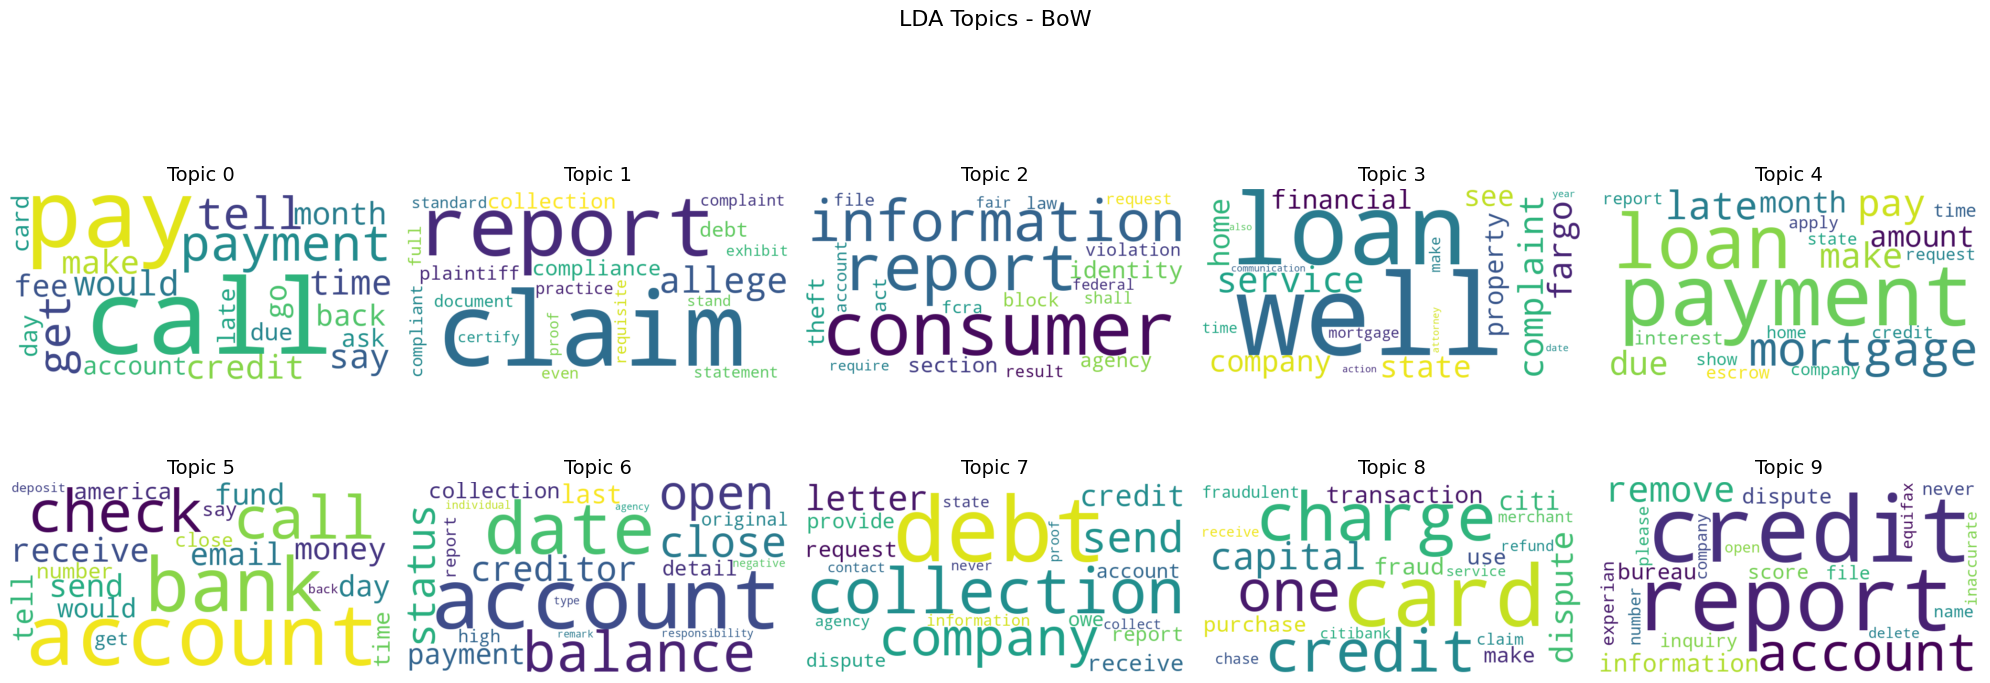

In [31]:
# Generate word clouds for LDA with BoW
plot_wordclouds_grid(lda_bow, lda_bow.num_topics, bow_dictionary, "LDA Topics - BoW")

The word clouds above illustrate the most important terms for each of the 10 topics identified by the LDA model using Bag of Words (BoW). 

**Dominant Themes**:
- Topic 0: Words like call, pay, and payment suggest a focus on payment-related complaints.
- Topic 1: Terms such as claim, report, and compliance point to regulatory or compliance issues.
- Topic 3 and Topic 4: Words like loan, mortgage, and interest highlight concerns related to loans and mortgages.

**Distinct Topics**:
- Topic 8: Includes terms like charge, card, and credit, indicating credit card disputes.
- Topic 9: Words such as report, credit, and dispute relate to credit reporting and disputes.
  
**Common Patterns**:
- Several topics (e.g., Topics 0, 4, 5) share terms like payment and account, showing overlaps in consumer concerns across different themes.

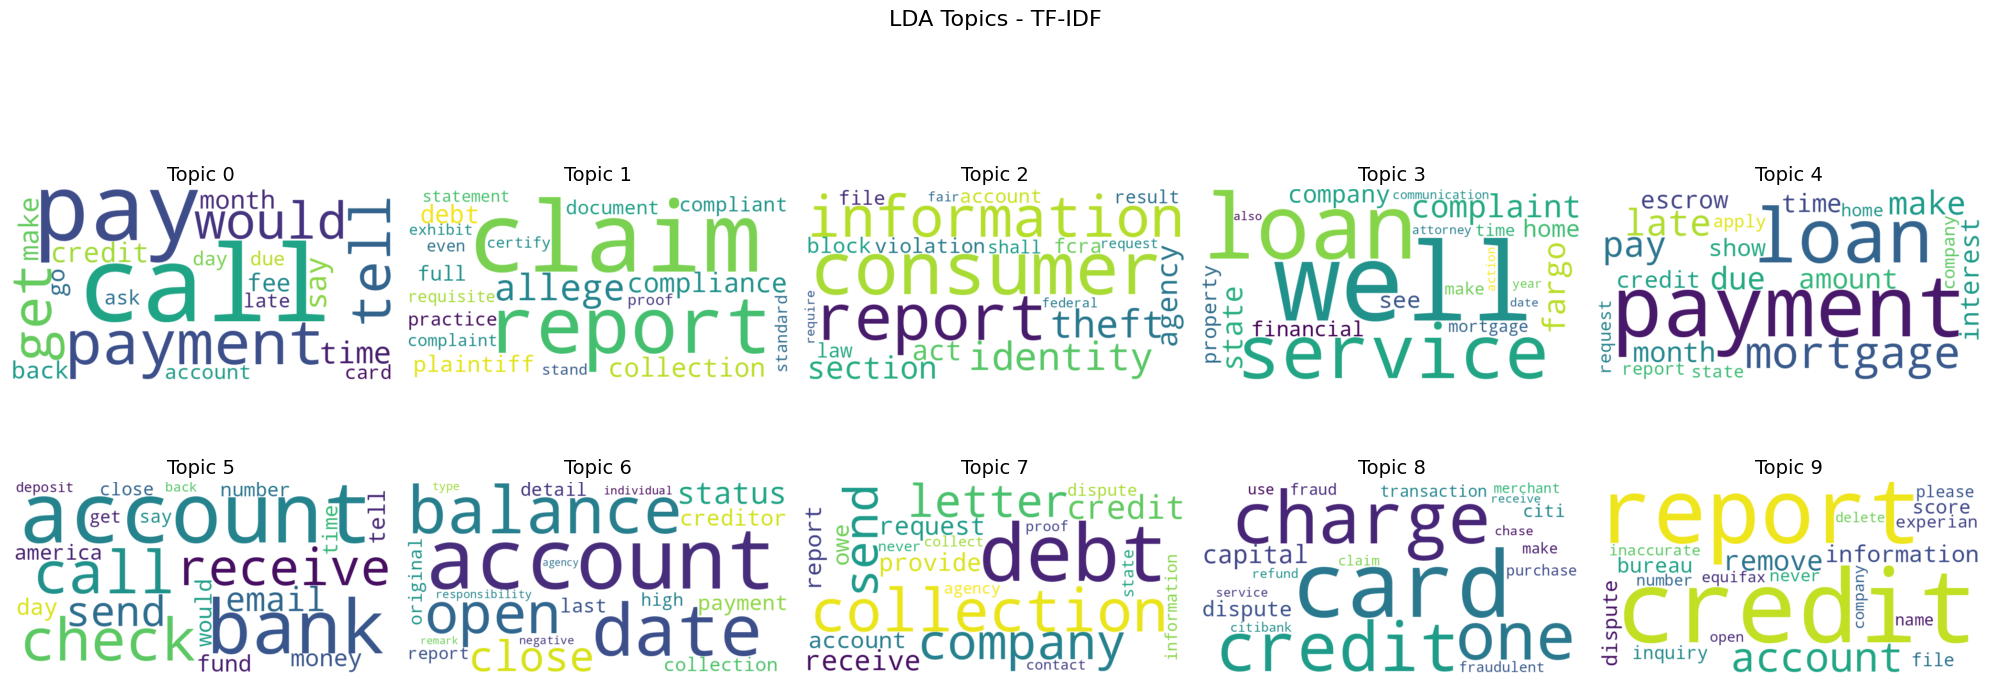

In [32]:
# Generate word clouds for LDA with TF-IDF
plot_wordclouds_grid(lda_tfidf, lda_tfidf.num_topics, tfidf_dictionary, "LDA Topics - TF-IDF")

The word clouds illustrate the most important terms for each of the 10 topics identified by the LDA model using TF-IDF. 

**Dominant Themes**:
- Topic 0: Words like call, pay, and payment highlight customer interactions and payment-related concerns.
- Topic 1: Focuses on claim, report, and compliance, likely related to disputes and regulatory issues.
- Topic 3 and Topic 4: Terms such as loan, mortgage, and interest emphasize financial and loan-related complaints.

**Distinct Topics**:
- Topic 8: Highlights terms like credit, card, and charge, indicating credit card issues.
- Topic 9: Focuses on account, report, and remove, pointing to account disputes and credit reporting issues.

**Comparison to BoW**:
- TF-IDF emphasizes unique and relevant terms, such as identity in Topic 2 and dispute in Topic 9, which are downplayed in BoW due to their overall frequency.
- TF-IDF provides a more nuanced understanding of topic-specific terms compared to BoW, highlighting distinct yet meaningful themes within the dataset.

### Evaluate Topic Distribution

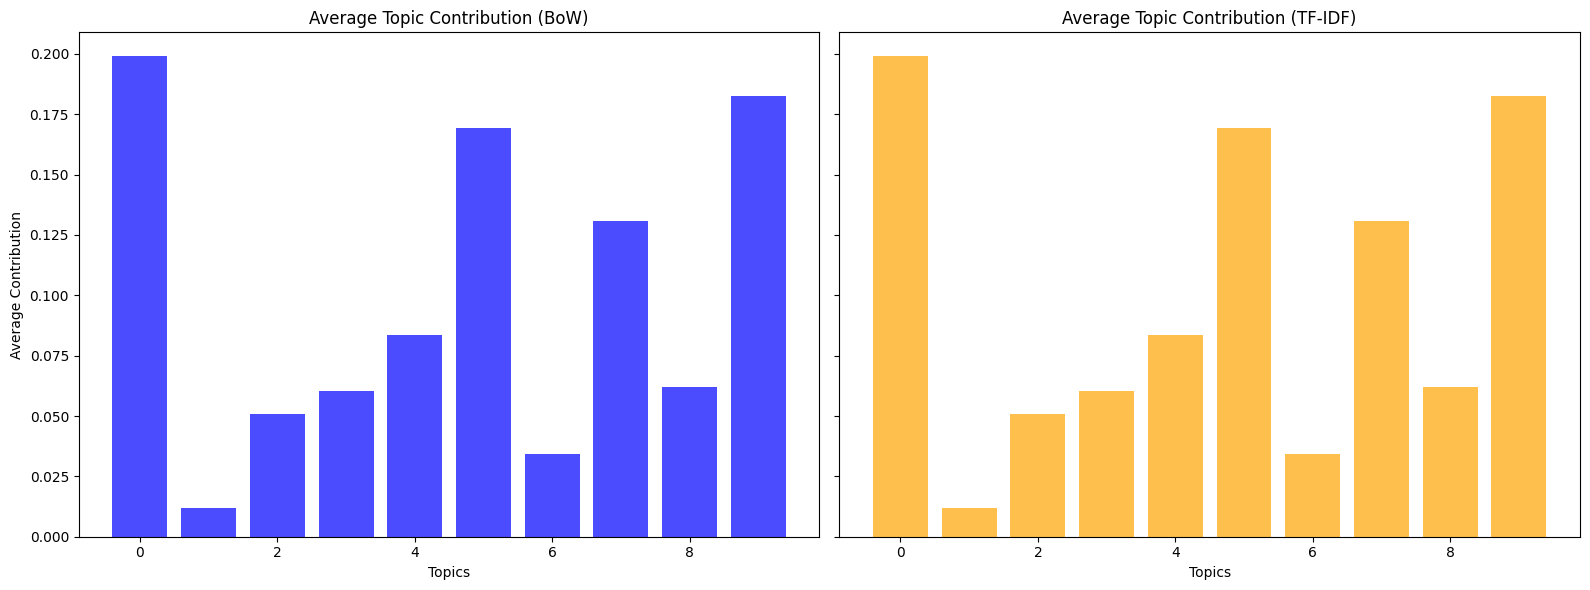

In [34]:
# Get topic distributions for each document
doc_topics_bow = [lda_bow.get_document_topics(doc) for doc in bow_corpus]
doc_topics_tfidf = [lda_tfidf.get_document_topics(doc) for doc in tfidf_corpus]

# Convert to matrix format
topic_matrix_bow = np.zeros((len(doc_topics_bow), lda_bow.num_topics))
for i, doc in enumerate(doc_topics_bow):
    for topic, prob in doc:
        topic_matrix_bow[i, topic] = prob

topic_matrix_tfidf = np.zeros((len(doc_topics_tfidf), lda_tfidf.num_topics))
for i, doc in enumerate(doc_topics_tfidf):
    for topic, prob in doc:
        topic_matrix_tfidf[i, topic] = prob

# Calculate average topic contributions
avg_topic_dist_bow = topic_matrix_bow.mean(axis=0)
avg_topic_dist_tfidf = topic_matrix_tfidf.mean(axis=0)

# Visualize BoW and TF-IDF topic distributions side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# BoW Topic Distribution
axes[0].bar(range(lda_bow.num_topics), avg_topic_dist_bow, alpha=0.7, color='blue')
axes[0].set_title("Average Topic Contribution (BoW)")
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("Average Contribution")

# TF-IDF Topic Distribution
axes[1].bar(range(lda_tfidf.num_topics), avg_topic_dist_tfidf, alpha=0.7, color='orange')
axes[1].set_title("Average Topic Contribution (TF-IDF)")
axes[1].set_xlabel("Topics")

# Adjust layout
plt.tight_layout()
plt.show()

The bar plots illustrate the average topic contributions across all documents for the LDA model, comparing results between Bag of Words (BoW) and TF-IDF vectorization methods:

**BoW**:
- Topic 0 has the highest average contribution, indicating its dominance across the dataset.
- Topics 1, 5, and 8 also show significant contributions.
- Topics 2, 4, and 6 have lower average contributions, indicating they are less prevalent.

**TF-IDF**:
- Similar to BoW, Topic 0 is the most dominant, followed by Topics 1, 5, and 8.
- Topics 2, 4, and 6 contribute less but remain consistent with the BoW distribution.

**Comparison**:
- Both methods produce comparable distributions, highlighting similar dominant and less prevalent topics.
- The TF-IDF method slightly adjusts contributions by emphasizing unique and important terms, which may refine the significance of specific topics.
- The distributions confirm that both BoW and TF-IDF capture consistent patterns in the dataset, with Topic 0 being the most prominent and a few smaller topics contributing less.

### Save Top Words

In [35]:
lda_bow_topics = {
    f"Topic {i}": [word for word, _ in lda_bow.show_topic(i, topn=10)]
    for i in range(lda_bow.num_topics)
}
with open("/Users/achshahrm/Library/Mobile Documents/com~apple~CloudDocs/Documents/IU International/Sem 05/Project Data Analysis/project/results/topics/lda_bow_topics.txt", "w") as f:
    for topic, words in lda_bow_topics.items():
        f.write(f"{topic}: {', '.join(words)}\n")

In [36]:
lda_tfidf_topics = {
    f"Topic {i}": [word for word, _ in lda_tfidf.show_topic(i, topn=10)]
    for i in range(lda_tfidf.num_topics)
}
with open("/Users/achshahrm/Library/Mobile Documents/com~apple~CloudDocs/Documents/IU International/Sem 05/Project Data Analysis/project/results/topics/lda_tfidf_topics.txt", "w") as f:
    for topic, words in lda_tfidf_topics.items():
        f.write(f"{topic}: {', '.join(words)}\n")

## NMF using Scikit-Learn

### With BoW Method

In [37]:
# Initialize NMF for BoW
nmf_bow = NMF(n_components=10, random_state=42, max_iter=500)
nmf_bow_topics = nmf_bow.fit_transform(bow_df)

# Extract top words for each topic
feature_names_bow = bow_vectorizer.get_feature_names_out()
bow_topic_words = []
for topic_idx, topic in enumerate(nmf_bow.components_):
    top_words = [feature_names_bow[i] for i in topic.argsort()[:-11:-1]]
    bow_topic_words.append(top_words)
    print(f"Topic {topic_idx}: {top_words}")

Topic 0: ['date', 'status', 'creditor', 'ok', 'balance', 'inquiry', 'open', 'close', 'type', 'responsibility']
Topic 1: ['consumer', 'report', 'information', 'block', 'agency', 'section', 'identity', 'theft', 'shall', 'file']
Topic 2: ['card', 'bank', 'receive', 'tell', 'say', 'send', 'charge', 'time', 'request', 'day']
Topic 3: ['claim', 'report', 'collection', 'compliance', 'plaintiff', 'allege', 'debt', 'compliant', 'requisite', 'document']
Topic 4: ['payment', 'late', 'make', 'pay', 'month', 'time', 'day', 'account', 'monthly', 'type']
Topic 5: ['account', 'open', 'balance', 'close', 'negative', 'number', 'original', 'potentially', 'check', 'bank']
Topic 6: ['issue', 'app', 'check', 'netspendxxxx', 'resolve', 'fix', 'know', 'deposit', 'mobile', 'experience']
Topic 7: ['debt', 'collector', 'collection', 'consumer', 'person', 'act', 'creditor', 'state', 'federal', 'communication']
Topic 8: ['loan', 'mortgage', 'document', 'service', 'seller', 'borrower', 'agreement', 'purchaser', 'da

### With TF-IDF Method

In [38]:
# Initialize NMF for TF-IDF
nmf_tfidf = NMF(n_components=10, random_state=42, max_iter=500)
nmf_tfidf_topics = nmf_tfidf.fit_transform(tfidf_df)

# Extract top words for each topic
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
tfidf_topic_words = []
for topic_idx, topic in enumerate(nmf_tfidf.components_):
    top_words = [feature_names_tfidf[i] for i in topic.argsort()[:-11:-1]]
    tfidf_topic_words.append(top_words)
    print(f"Topic {topic_idx}: {top_words}")

Topic 0: ['report', 'credit', 'remove', 'bureau', 'inaccurate', 'score', 'information', 'agency', 'experian', 'delete']
Topic 1: ['loan', 'mortgage', 'pay', 'company', 'tell', 'home', 'time', 'say', 'month', 'ask']
Topic 2: ['debt', 'collection', 'owe', 'company', 'collect', 'agency', 'collector', 'pay', 'allege', 'validation']
Topic 3: ['payment', 'late', 'make', 'pay', 'month', 'fee', 'day', 'date', 'balance', 'miss']
Topic 4: ['card', 'charge', 'credit', 'capital', 'fee', 'use', 'citi', 'purchase', 'pay', 'balance']
Topic 5: ['account', 'open', 'close', 'balance', 'date', 'status', 'creditor', 'remove', 'number', 'collection']
Topic 6: ['letter', 'dispute', 'send', 'request', 'information', 'provide', 'verify', 'receive', 'consumer', 'proof']
Topic 7: ['bank', 'check', 'america', 'money', 'chase', 'fund', 'deposit', 'tell', 'transfer', 'day']
Topic 8: ['identity', 'theft', 'information', 'victim', 'fraudulent', 'consumer', 'block', 'ftc', 'report', 'file']
Topic 9: ['inquiry', 'hard

### Evaluate Topic Coherence

In [39]:
# Function to compute coherence for NMF topics
def compute_nmf_coherence(nmf_model, feature_names, texts, dictionary, coherence='c_v'):
    # Extract top words for each topic
    topics = []
    for topic_idx in range(nmf_model.n_components):
        top_words = [feature_names[i] for i in nmf_model.components_[topic_idx].argsort()[:-11:-1]]
        topics.append(top_words)
    
    # Use Gensim's CoherenceModel
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=coherence)
    coherence_score = coherence_model.get_coherence()
    
    return coherence_score

# Tokenized texts from preprocessed data
tokenized_texts = data_preprocessed['complaints_text'].str.split()

# Create a Gensim dictionary
dictionary = Dictionary(tokenized_texts)

# Compute coherence for NMF with BoW
nmf_bow_coherence = compute_nmf_coherence(nmf_bow, feature_names_bow, tokenized_texts, dictionary)
print(f"NMF with BoW Coherence Score: {nmf_bow_coherence:.4f}")

# Compute coherence for NMF with TF-IDF
nmf_tfidf_coherence = compute_nmf_coherence(nmf_tfidf, feature_names_tfidf, tokenized_texts, dictionary)
print(f"NMF with TF-IDF Coherence Score: {nmf_tfidf_coherence:.4f}")

NMF with BoW Coherence Score: 0.5985
NMF with TF-IDF Coherence Score: 0.5596


### Evaluate Word Cloud Visualization

In [40]:
# Word Cloud for NMF topics
def plot_nmf_wordclouds_grid(nmf_model, num_topics, feature_names, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for topic_idx, ax in enumerate(axes[:num_topics]):
        wordcloud = WordCloud(width=800, height=400, background_color='white')
        topic_terms = {feature_names[i]: nmf_model.components_[topic_idx][i] for i in nmf_model.components_[topic_idx].argsort()[:-21:-1]}
        wordcloud.generate_from_frequencies(topic_terms)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic {topic_idx}", fontsize=14)
    
    for ax in axes[num_topics:]:
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

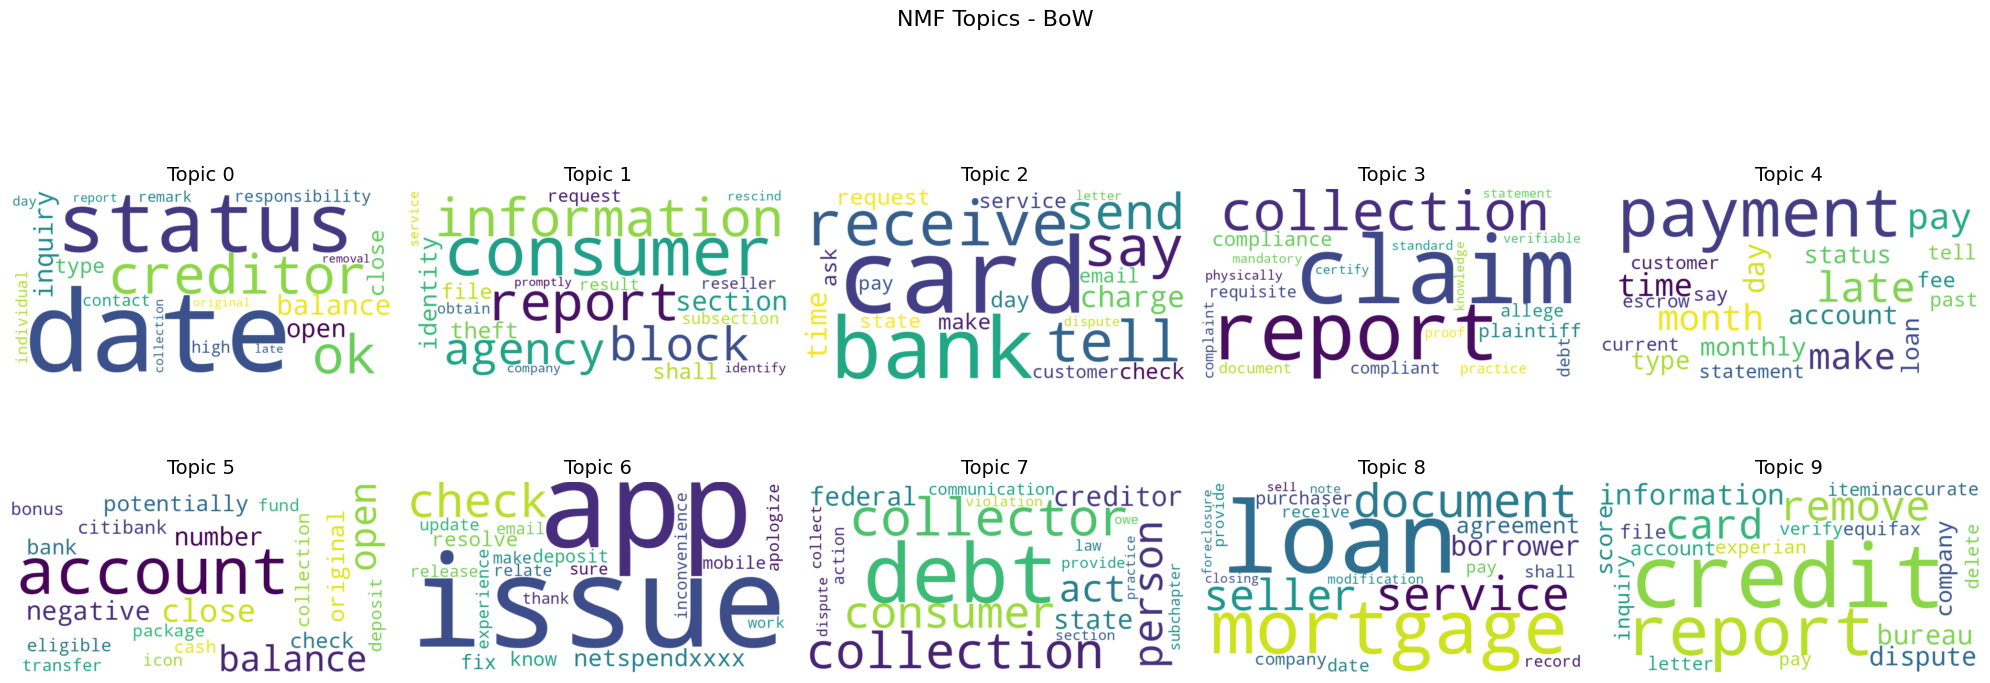

In [41]:
# Generate word clouds for NMF with BoW
plot_nmf_wordclouds_grid(nmf_bow, nmf_bow.n_components, feature_names_bow, "NMF Topics - BoW")

The word clouds illustrate the top words for each of the 10 topics identified by the NMF model using Bag of Words (BoW).

**Dominant Themes**:
- Topic 0: Focuses on terms like date, status, and creditor, likely related to account statuses and balances.
- Topic 4: Includes payment, late, and loan, highlighting payment-related complaints.
- Topic 8: Words like mortgage, loan, and document indicate issues related to mortgages and loans.

**Distinct Topics**:
- Topic 2: Highlights terms like card, bank, and receive, pointing to concerns about credit cards and banking services.
- Topic 9: Includes credit, report, and remove, focusing on disputes related to credit reporting.
**Common Patterns**:
- Several topics (e.g., Topics 4, 5) include terms like account and balance, showing overlaps in financial concerns across themes.

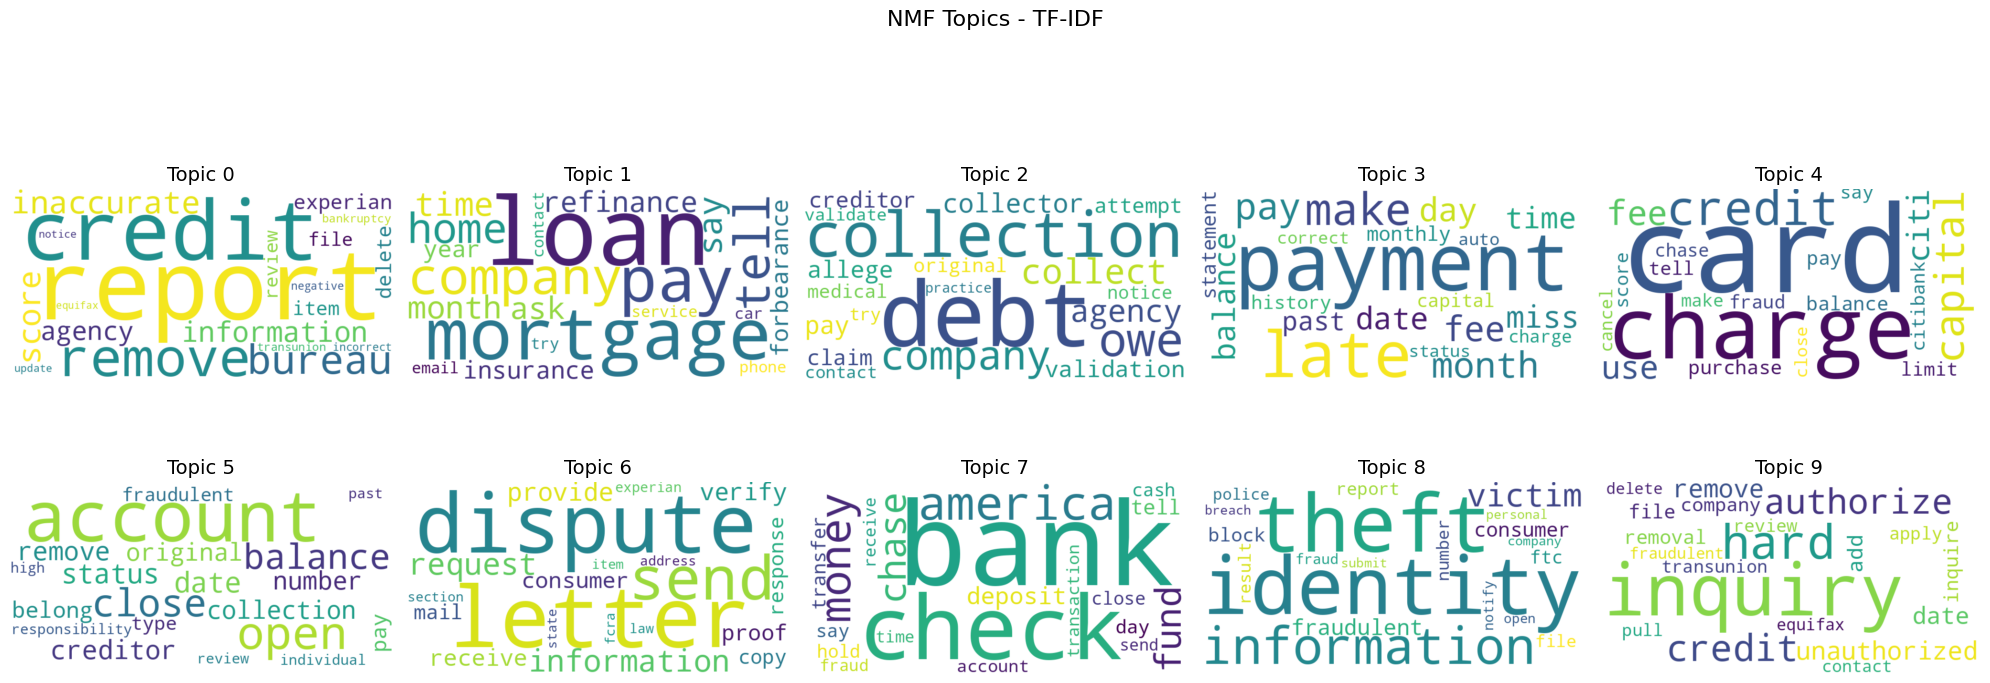

In [42]:
# Generate word clouds for NMF with TF-IDF
plot_nmf_wordclouds_grid(nmf_tfidf, nmf_tfidf.n_components, feature_names_tfidf, "NMF Topics - TF-IDF")

The word clouds above represent the top words for each of the 10 topics identified by the NMF model using TF-IDF.

**Dominant Themes**:
- Topic 0: Words like report, credit, and remove highlight disputes about credit reports and inaccurate information.
- Topic 1: Includes terms such as loan, mortgage, and company, indicating loan and mortgage-related concerns.
- Topic 4: Focuses on card, charge, and credit, pointing to credit card usage and associated fees.

**Distinct Topics**:
- Topic 3: Highlights terms like payment, late, and date, which emphasize payment timing and overdue accounts.
- Topic 9: Features terms like identity, theft, and inquiry, suggesting issues related to identity theft and unauthorized actions.

**Comparison to BoW**:
- TF-IDF emphasizes unique and specific terms, such as fraudulent (Topic 8) and unauthorized (Topic 9), which might be downplayed in BoW due to their frequency across documents.
- The NMF model with TF-IDF effectively identifies distinct topics, including payment disputes, credit report inaccuracies, and identity theft.

### Evaluate Topic Distribution

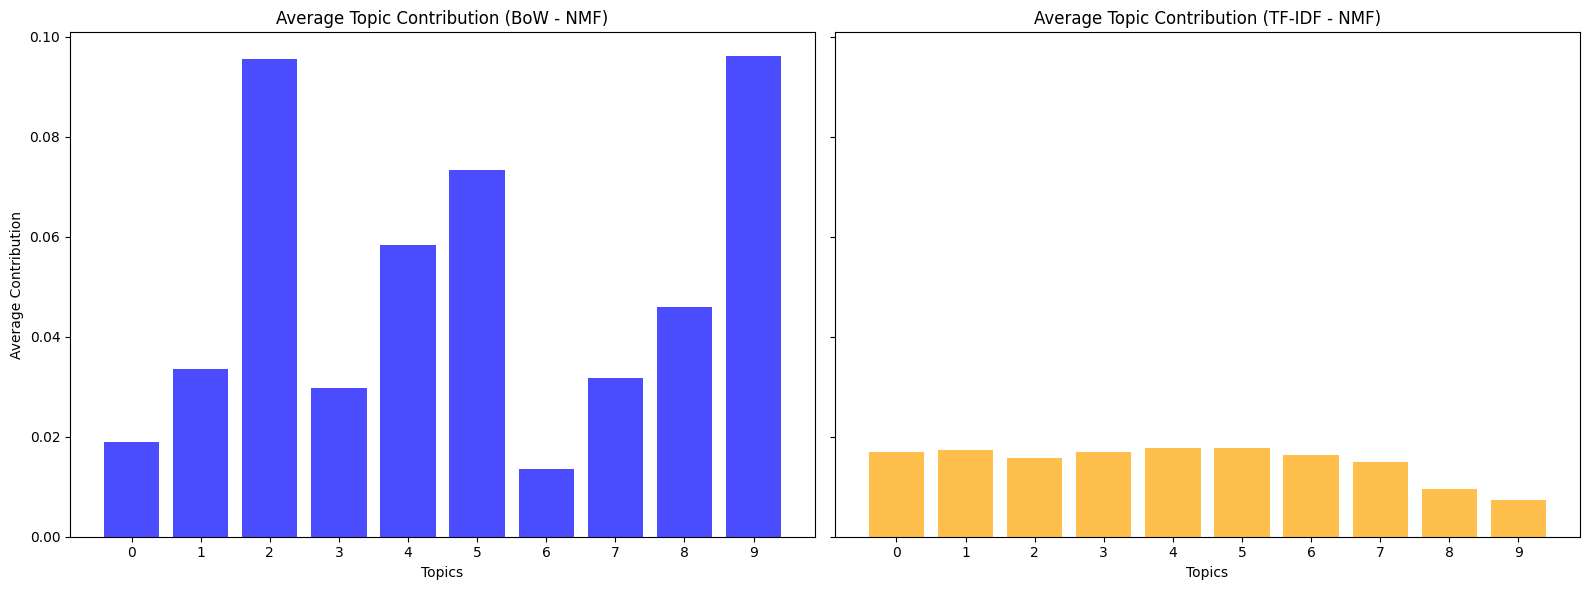

In [43]:
# Compute the average topic contributions for BoW and TF-IDF
avg_topic_dist_bow_nmf = nmf_bow_topics.mean(axis=0)
avg_topic_dist_tfidf_nmf = nmf_tfidf_topics.mean(axis=0)

# Plot side-by-side bar charts for BoW and TF-IDF
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# BoW Topic Distribution
axes[0].bar(range(nmf_bow.n_components), avg_topic_dist_bow_nmf, color='blue', alpha=0.7)
axes[0].set_title("Average Topic Contribution (BoW - NMF)")
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("Average Contribution")
axes[0].set_xticks(range(nmf_bow.n_components))

# TF-IDF Topic Distribution
axes[1].bar(range(nmf_tfidf.n_components), avg_topic_dist_tfidf_nmf, color='orange', alpha=0.7)
axes[1].set_title("Average Topic Contribution (TF-IDF - NMF)")
axes[1].set_xlabel("Topics")
axes[1].set_xticks(range(nmf_tfidf.n_components))

# Adjust layout and display
plt.tight_layout()
plt.show()

The bar plots above compare the average topic contributions for the NMF model using Bag of Words (BoW) and TF-IDF vectorization methods:

**BoW**:
- Topics 2, 5, and 9 have the highest average contributions, indicating their dominance across the dataset.
- Topics 0, 1, 6, and 7 have lower contributions, showing that these themes are less prevalent in the dataset.

**TF-IDF**:
- Contributions are more evenly distributed across all topics.
- No single topic dominates, suggesting that TF-IDF balances the influence of frequent and unique terms, leading to more uniform topic representation.

**Comparison**:
- The BoW distribution shows clear topic dominance (e.g., Topics 2 and 9), which may highlight specific, recurring themes.
- TF-IDF provides a more balanced representation, possibly capturing subtle nuances in the dataset by down-weighting overly frequent terms.

### Save Top Words

In [44]:
nmf_bow_topics = {
    f"Topic {i}": [feature_names_bow[j] for j in nmf_bow.components_[i].argsort()[:-11:-1]]
    for i in range(nmf_bow.n_components)
}
with open("/Users/achshahrm/Library/Mobile Documents/com~apple~CloudDocs/Documents/IU International/Sem 05/Project Data Analysis/project/results/topics/nmf_bow_topics.txt", "w") as f:
    for topic, words in nmf_bow_topics.items():
        f.write(f"{topic}: {', '.join(words)}\n")

In [45]:
nmf_tfidf_topics = {
    f"Topic {i}": [feature_names_tfidf[j] for j in nmf_tfidf.components_[i].argsort()[:-11:-1]]
    for i in range(nmf_tfidf.n_components)
}
with open("/Users/achshahrm/Library/Mobile Documents/com~apple~CloudDocs/Documents/IU International/Sem 05/Project Data Analysis/project/results/topics/nmf_tfidf_topics.txt", "w") as f:
    for topic, words in nmf_tfidf_topics.items():
        f.write(f"{topic}: {', '.join(words)}\n")

## BERTopic using bertopic

In [47]:
# Extract the complaints_text column as input for BERTopic
documents = data_preprocessed['complaints_text'].sample(n=5000, random_state=42).tolist()

# Embedding model
embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")

# Initialize PCA for dimensionality reduction
pca_model = PCA(n_components=50)

# Initialize BERTopic with custom embedding model and dimensionality reduction
topic_model = BERTopic(umap_model=pca_model, embedding_model=embedding_model, verbose=True)

# Fit BERTopic model
topics, probs = topic_model.fit_transform(documents)

2025-01-23 23:19:00,868 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2025-01-23 23:19:25,033 - BERTopic - Embedding - Completed ✓
2025-01-23 23:19:25,033 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-23 23:19:25,060 - BERTopic - Dimensionality - Completed ✓
2025-01-23 23:19:25,062 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-23 23:19:27,624 - BERTopic - Cluster - Completed ✓
2025-01-23 23:19:27,627 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-23 23:19:27,842 - BERTopic - Representation - Completed ✓


### Evaluate Topic Coherence

In [48]:
# Tokenized documents (from preprocessed data)
tokenized_documents = [doc.split() for doc in documents]  

# Create a Gensim dictionary
dictionary = Dictionary(tokenized_documents)

# Extract topics from BERTopic
topics = topic_model.get_topics()

# Prepare topics for Gensim CoherenceModel
formatted_topics = []
for topic_id, words in topics.items():
    formatted_topics.append([word[0] for word in words])

# Compute coherence score
coherence_model = CoherenceModel(
    topics=formatted_topics, texts=tokenized_documents, dictionary=dictionary, coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print(f"BERTopic Coherence Score: {coherence_score:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

BERTopic Coherence Score: 0.5177


### Inspect Topics

In [49]:
# Print the top words for each topic
for topic_idx in range(len(topic_model.get_topics())):
    print(f"Topic {topic_idx}: {topic_model.get_topic(topic_idx)}")

Topic 0: [('account', 0.10579166588435245), ('verifiable', 0.08648256877463895), ('report', 0.08411828721734262), ('verify', 0.08368516292495926), ('proof', 0.0740750563098894), ('contract', 0.07103186491805706), ('must', 0.07032228721403123), ('remove', 0.06940124660145607), ('original', 0.06870490836617649), ('credit', 0.06867335084997653)]
Topic 1: [('claim', 0.1450170760272196), ('compliance', 0.08414546607719231), ('plaintiff', 0.07900805010514428), ('compliant', 0.06603586396000774), ('requisite', 0.06393315213943199), ('collection', 0.06180430752736089), ('report', 0.06062212442365216), ('allege', 0.05931241393370748), ('full', 0.04610746166677642), ('debt', 0.04388421923889382)]
Topic 2: [('report', 0.10114099707259795), ('debt', 0.06662461469347811), ('information', 0.05722784584597975), ('collection', 0.051760217784931686), ('person', 0.05047579128717721), ('credit', 0.04944013085392005), ('violation', 0.03997333143159222), ('account', 0.039803388790963616), ('proof', 0.03616

### Visualize topic distributions

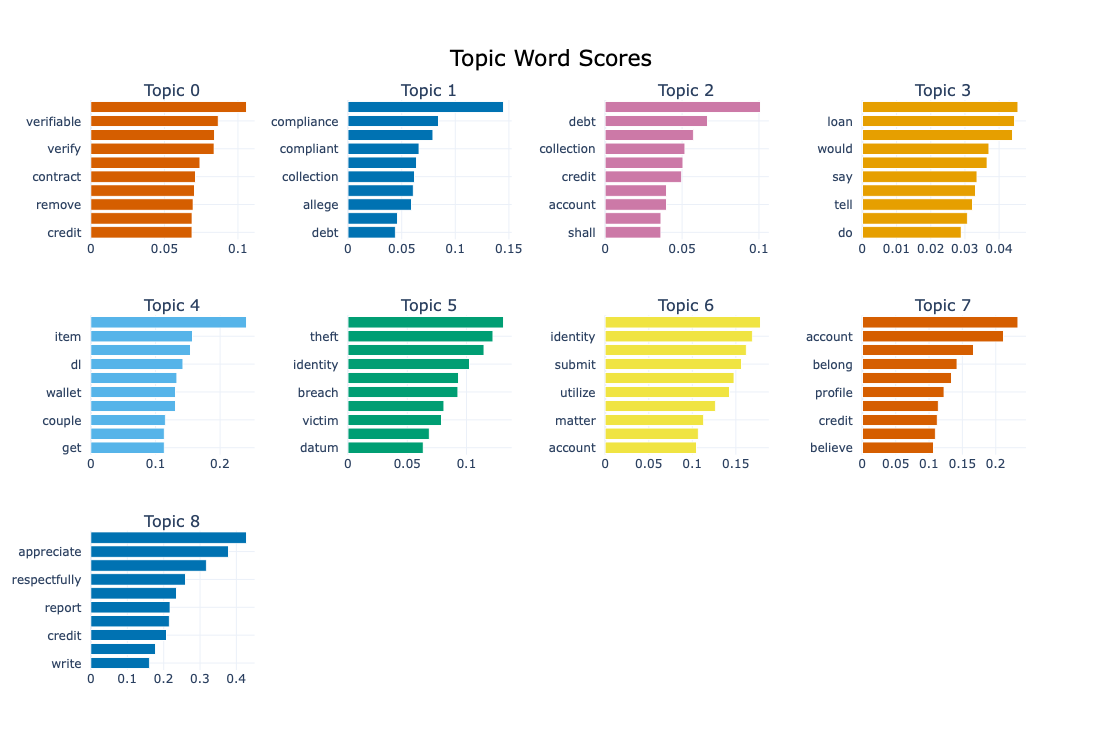

In [50]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)

The bar plots above represent the top contributing words for each topic identified by the BERTopic model, along with their respective scores.

**Dominant Words for Each Topic**:
- Topic 0: Terms like verifiable, verify, and credit suggest themes around credit verification and contracts.
- Topic 5: Words such as theft, identity, and breach indicate concerns related to identity theft and breaches.
- Topic 8: High-scoring terms like appreciate, respectfully, and report suggest themes around communication or formal complaints.

**Topic-Specific Insights**:
- Topic 2: Words like debt and collection highlight issues surrounding debt collection.
- Topic 7: Focuses on account, belong, and profile, indicating account-related concerns.
- Topic 4: Includes words like item and wallet, which could indicate specific product-related issues.

**Relevance Scores**:
- The word scores quantify the importance of each word to its respective topic, with higher scores indicating stronger relevance.

### Visualize topic hierarchies

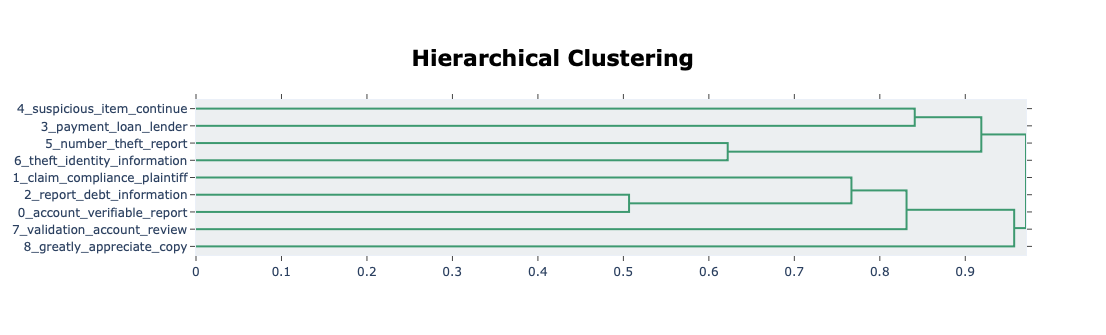

In [51]:
topic_model.visualize_hierarchy()

The dendrogram above represents the hierarchical clustering of topics generated by the BERTopic model. 

**Clustered Topics**:
- Topics 4 (suspicious_item_continue) and 3 (payment_loan_lender) are closely related, indicating overlap in their themes.
- Topics 5 (number_theft_report) and 6 (theft_identity_information) are clustered together, suggesting a focus on identity theft and reporting issues.

**Distinct Topics**:
- Topics like 8 (greatly_appreciate_copy) and 7 (validation_account_review) remain farther apart, indicating their uniqueness compared to other topics.

**Branching Structure**:
- Topics with shorter horizontal branches (e.g., 4 and 3) exhibit higher similarity.
- Longer branches represent greater divergence in themes, such as Topic 8 being more distinct.

### Visualize inter-topic distances

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


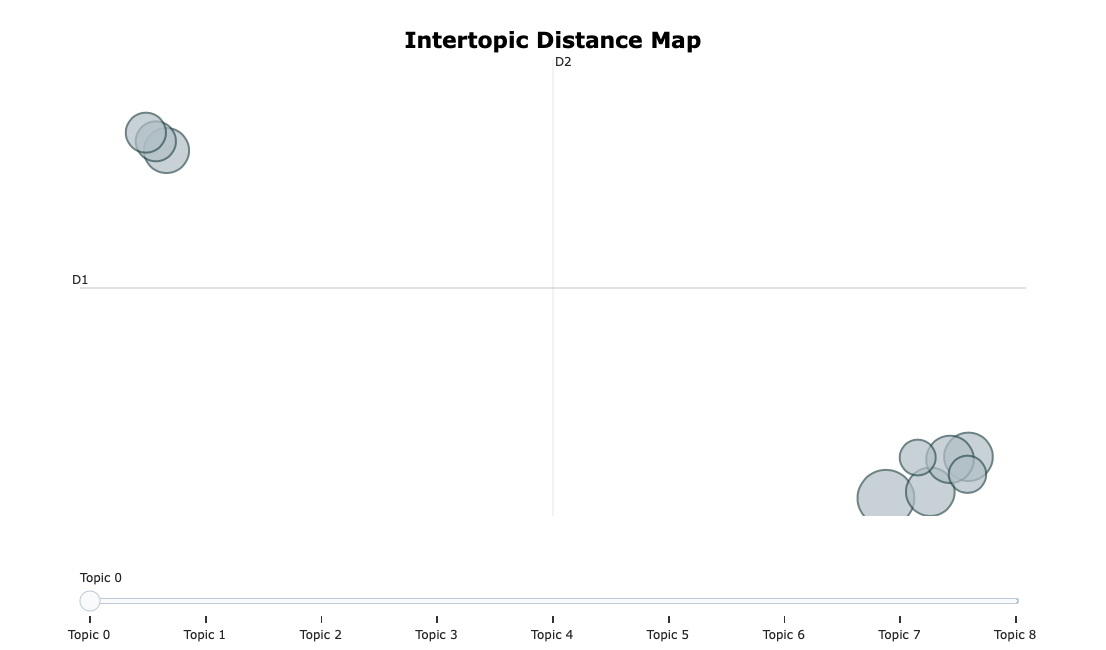

In [52]:
topic_model.visualize_topics()

- Topic Distribution and Separation: The Intertopic Distance Maps show how distinct or overlapping the identified topics are. Topics represented as circles vary in size, indicating their significance (larger circles represent more prevalent topics).
- Clustering of Topics: Topics 6 to 8 are closely clustered in one quadrant, suggesting they share overlapping characteristics or themes.
- Isolated Topics: Topic 0 and Topic 4 are noticeably distant from the rest, highlighting their distinctiveness.
- Interactive Insights: When specific topics are highlighted, their relative importance and proximity to others are displayed. This helps in understanding how unique or connected a topic is within the broader theme.

### Additional Data For Evaluation

In [53]:
print(topic_model.get_topic_info())

   Topic  Count                                    Name  \
0     -1   4831        -1_account_credit_report_payment   
1      0     30      0_account_verifiable_report_verify   
2      1     22  1_claim_compliance_plaintiff_compliant   
3      2     22    2_report_debt_information_collection   
4      3     21             3_payment_loan_lender_would   
5      4     19           4_suspicious_item_continue_dl   
6      5     15          5_number_theft_report_identity   
7      6     15     6_theft_identity_information_submit   
8      7     13      7_validation_account_review_belong   
9      8     12  8_greatly_appreciate_copy_respectfully   

                                      Representation  \
0  [account, credit, report, payment, call, pay, ...   
1  [account, verifiable, report, verify, proof, c...   
2  [claim, compliance, plaintiff, compliant, requ...   
3  [report, debt, information, collection, person...   
4  [payment, loan, lender, would, call, say, ask,...   
5  [suspicious

### Save Top Words

In [54]:
bertopic_topics = topic_model.get_topics()
with open("/Users/achshahrm/Library/Mobile Documents/com~apple~CloudDocs/Documents/IU International/Sem 05/Project Data Analysis/project/results/topics/bertopic_topics.txt", "w") as f:
    for topic_id, words in bertopic_topics.items():
        word_list = [word[0] for word in words]  # Extract just the words
        f.write(f"Topic {topic_id}: {', '.join(word_list)}\n")

# Overall Evaluation

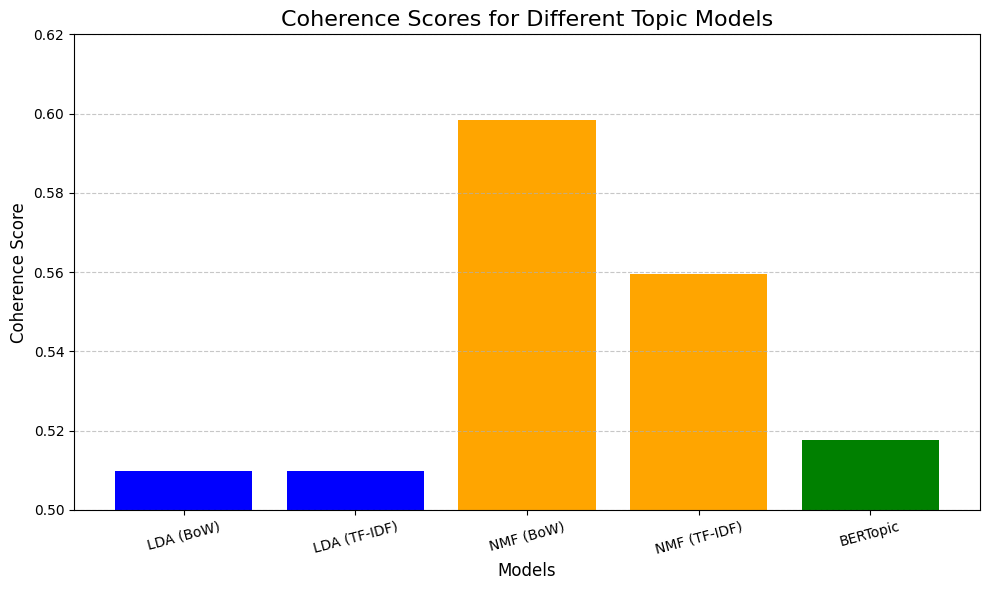

In [55]:
# Coherence scores for different models
models = ["LDA (BoW)", "LDA (TF-IDF)", "NMF (BoW)", "NMF (TF-IDF)", "BERTopic"]
scores = [0.5097427521316732, 0.5097427521316732, 0.5985, 0.5596, 0.5177]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['blue', 'blue', 'orange', 'orange', 'green'])
plt.title("Coherence Scores for Different Topic Models", fontsize=16)
plt.ylabel("Coherence Score", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(0.5, 0.62)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, rotation=15)

# Display the plot
plt.tight_layout()
plt.show()

This bar chart compares the coherence scores of the different topic modeling approaches used in the analysis:

- LDA (BoW and TF-IDF): Both achieved coherence scores of approximately 0.51, demonstrating similar performance and moderate coherence across the extracted topics.
- NMF (BoW and TF-IDF): NMF with BoW outperformed all models with the highest coherence score of 0.60, while NMF with TF-IDF achieved a score of 0.56.
- BERTopic: BERTopic had a coherence score of 0.52, slightly better than LDA but not as high as NMF.

# Conclusion

This project explored topic modeling on consumer complaint data using multiple algorithms—LDA, NMF, and BERTopic—along with Bag-of-Words (BoW) and TF-IDF vectorization techniques. The results of these models were evaluated using coherence scores and visualizations, leading to the following insights:

**Coherence Scores**:
- NMF with BoW emerged as the most effective model, achieving the highest coherence score of 0.60, indicating well-defined and interpretable topics.
- NMF with TF-IDF followed closely with a coherence score of 0.56, showing the model's robustness across different vectorization techniques.
- BERTopic, despite its slightly lower coherence score of 0.52, offers intuitive interpretability through interactive visualizations like hierarchical clustering and intertopic distance maps.
- LDA models (BoW and TF-IDF) performed equally with coherence scores of 0.51, demonstrating stable but less competitive topic quality compared to NMF.

**Visual Insights**:
- Word Clouds: Highlighted the most representative words for each topic, aiding in interpreting and labeling the topics.
- Topic Distribution Graphs: Provided insights into the average contributions of topics across the dataset. Both NMF and LDA showed variations in topic dominance, with NMF's topics being more evenly distributed.
- Intertopic Distance Maps (BERTopic): Revealed clear clustering of related topics and separation of distinct topics, demonstrating BERTopic's strength in visualization.
- Hierarchical Clustering (BERTopic): Helped group related topics, offering a deeper understanding of topic relationships.

**Key Takeaways**:
- NMF with BoW is recommended for datasets requiring high coherence and clear topic definitions, making it ideal for generating actionable insights.
- BERTopic, while slightly less coherent, excels in interpretability and visualization, making it a powerful tool for exploratory analysis and presentations.
- LDA, though outperformed by NMF, remains a solid baseline approach for topic modeling, particularly when interpretability and simplicity are prioritized.

This project successfully identified key topics in consumer complaint data, offering a scalable methodology for understanding customer feedback. The results can guide businesses in addressing recurring issues and enhancing customer experience.